In [32]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Parameters for the Faroe Bank Channel

$H=500$ m, $L = 10$ km, $f=5 \times 10^{-5} $ s$^{-1}$, $g'=\dfrac{\delta \rho}{\rho_{0}} g = 4.3 \times 10^{-3}$ m/s$^{2}$.

### Non-dimensionalization

\begin{align}
x = x^{\star}/L_{d} ,\quad y = y^{\star}/L, \quad v = v^{\star} / \sqrt{g'H}, \quad d = d^{\star}/H, \quad h = h^{\star}/H.
\end{align}
with $L_{d} = \sqrt{g'H}/f$.

In [33]:
def f(ϕ): return 2. * (2*np.pi)/(60**2 * 24.) * np.sin(np.deg2rad(ϕ))

In [54]:
δρ = 0.45
ρ0 = 1028.
g = 9.81
gp = (δρ/ρ0)*g

H = 500.
L = 10.e3

W = 10.e3
Hsill = 400.
Lsill = 100.e3
ϕ = 62.
f0 = f(ϕ)
αsill = 5.8e-6 # What is this???
ηinf = 1000.

Ld = np.sqrt(gp*H)/f0
print(f"Ld = {round(Ld/1000., 2)} km")

rsill = f0**2 / (gp*αsill)
κsill = 2./rsill

λ = L/Lsill # inverse along-channel length of sill

κreduced = 1.0

# discretization
ny = 500; Ly = 160.; dy = Ly/ny
nx = 200; Lx = 6.; dx = Lx/nx

y = np.arange(-Ly/2.+dy/2.,+Ly/2.,dy)[np.newaxis,:]
x = np.arange(-Lx/2.+dx/2.,+Lx/2.,dx)[:,np.newaxis]

κ = κsill *  ((1. - κreduced) * np.exp(-(λ/2.*y)**2) + κreduced)

print(f"κ = {round(κsill, 3)} (non-dimensional), αcode = {round(κsill/2., 3)} (non-dimensional), r = {round(rsill, 3)}")

B = ηinf/H
print(f"B = {B}")

print(f"sill = {Hsill/H}")
# arbitrary gamma for reference

Ld = 11.41 km
κ = 3.021 (non-dimensional), αcode = 1.51 (non-dimensional), r = 0.662
B = 2.0
sill = 0.8


In [55]:
# sill
h0 = np.exp(-(λ*y)**2) * Hsill/H
h = (h0 + 0.5*κ*x**2)

(3.0, -3.0)

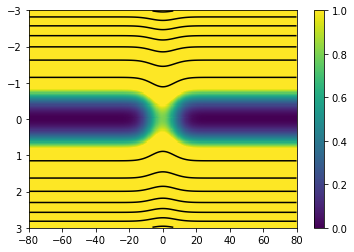

In [56]:
plt.pcolor(y,x,h)
plt.clim([0.,1.])
plt.colorbar()
plt.contour(y.flatten(),x.flatten(),h, colors='k')
plt.ylim([Lx/2.,-Lx/2.])

#### Calculate width of zero-PV solution by solving 8th order polynomial (reduced to quartic)

In [57]:
def calc_width(Q):
    a = (1.+κ)/8.
    b = h0 - B
    e = (72.*Q**2)/(κ*(1.+κ))
    
    p = (-3.*b**2)/(8.*a**2)
    q = b**3/(8.*a**3)

    Δ0 = 12.*a*e
    Δ1 = 27.*b**2*e

    T = ( (Δ1 + np.sqrt(Δ1**2 - 4.*Δ0**3))/2. )**(1./3.)

    S = (1./2.) * np.sqrt(
        -(2./3.)*p + (1./(3.*a))*(T + Δ0/T)
    )
    
    x3 = -b/(4*a) + S + (1./2.)*np.sqrt( -4.*S**2 - 2*p - q/S)
    x4 = -b/(4*a) + S - (1./2.)*np.sqrt( -4.*S**2 - 2*p - q/S)
    
    w3 = np.sqrt(x3)
    w4 = np.sqrt(x4)
    
    w = np.zeros_like(w3)
    w[y<0.] = w3[y<0.]
    w[y>=0.] = w4[y>=0.]

    return w

### Search for critical solution
Here, we loop through This is equivalent to maximizing $Q$, as in Borenas and Lundberg.

Qcrit = 0.538


/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_68941/203758857.py:15: RuntimeWarning: invalid value encountered in true_divide
  -(2./3.)*p + (1./(3.*a))*(T + Δ0/T)
/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_68941/203758857.py:12: RuntimeWarning: invalid value encountered in sqrt
  T = ( (Δ1 + np.sqrt(Δ1**2 - 4.*Δ0**3))/2. )**(1./3.)


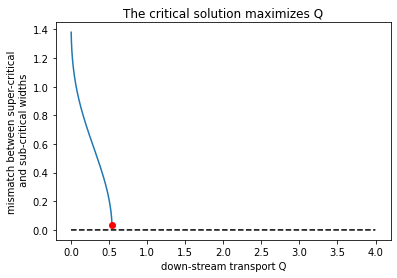

In [58]:
mismatch_vec = []
Q_vec = np.arange(0.,B*2,B/1000.)

Q_crit = np.nan
mismatch_crit = 0.1

for Q in Q_vec:
    w = calc_width(Q)
    mismatch = np.abs(w[0,np.int64(ny/2.)] - w[0,np.int64(ny/2.)-1])
    mismatch_vec.append(mismatch)
    if mismatch < mismatch_crit:
        mismatch_crit = mismatch
        Q_crit = Q
        w_crit = w
    
plt.plot(Q_vec, mismatch_vec)
plt.plot(Q_vec, 0.*Q_vec, 'k--')
plt.plot(Q_crit, mismatch_crit, 'ro')
plt.xlabel("down-stream transport Q")
plt.ylabel("mismatch between super-critical\n and sub-critical widths")
plt.title("The critical solution maximizes Q")

print(f"Qcrit = {Q_crit}")

#### Plotting the solution

In [59]:
xc = 12.*Q_crit/(κ*(1.+κ)*w_crit**3)
xp = x-xc

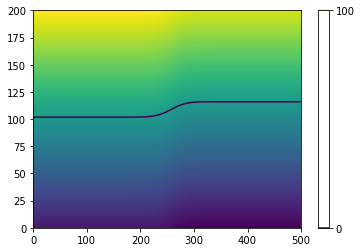

In [60]:
plt.pcolor(xp)
plt.contour(xp, levels=[0.,100])
plt.colorbar()

In [61]:
d = 0.5 * (1.+κ) * ((0.5*w_crit)**2 - xp**2)
d[d<0.] = np.nan

(3.0, -3.0)

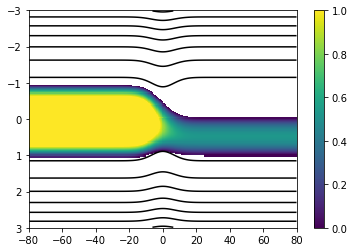

In [62]:
plt.contour(y.flatten(),x.flatten(),h, colors='k')
q = plt.pcolor(y,x,d)
q.set_clim([0,1])
plt.colorbar()
plt.ylim([Lx/2.,-Lx/2.])

(3.0, -3.0)

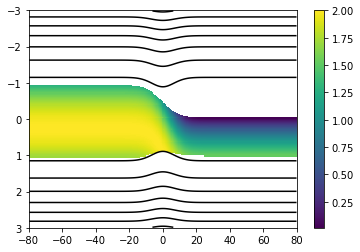

In [63]:
plt.contour(y.flatten(),x.flatten(),h, colors='k')
plt.pcolor(y,x,d+h)
plt.colorbar()
plt.ylim([Lx/2.,-Lx/2.])

In [64]:
αi

-2.010268982892298

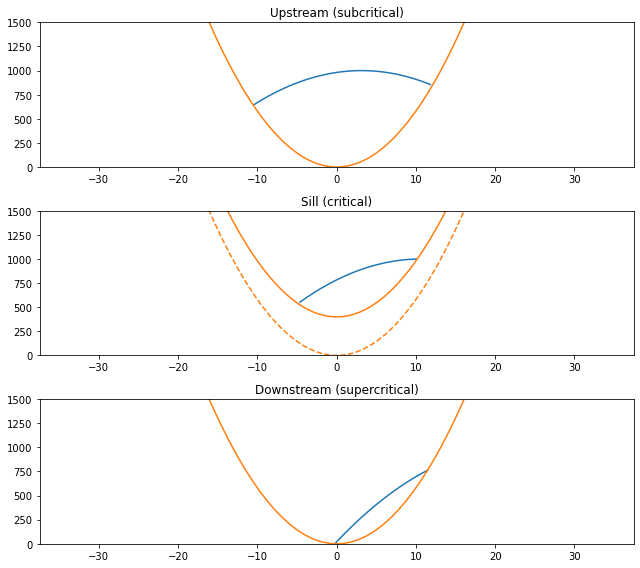

In [65]:
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(x*Ld/1000., (d+h)[:,0]*H)
plt.plot(x*Ld/1000., h[:,0]*H)
plt.title("Upstream (subcritical)")
plt.ylim([0.,3.0*H])

plt.subplot(3,1,2)
plt.plot(x*Ld/1000., (d+h)[:,np.int64(ny/2.)]*H)
plt.plot(x*Ld/1000., h[:,np.int64(ny/2.)]*H)
plt.plot(x*Ld/1000., h[:,0]*H, "C1--")
plt.title("Sill (critical)")
plt.ylim([0.,3.0*H])

plt.subplot(3,1,3)
plt.plot(x*Ld/1000., (d+h)[:,-1]*H)
plt.plot(x*Ld/1000., h[:,-1]*H)
plt.title("Downstream (supercritical)")
plt.ylim([0.,3.0*H])

plt.tight_layout()

In [66]:
np.nanmax(d+h)*H

999.9999999527879

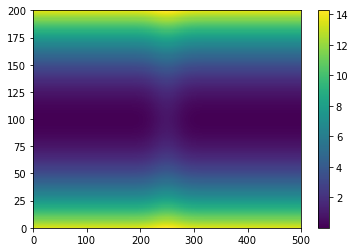

In [67]:
plt.pcolor(h)
plt.colorbar()

In [68]:
Δz = B-Hsill/H

In [69]:
Q_crit

0.538

In [70]:
Δz**2/(2+rsill)*np.sqrt(3*rsill/2.)

0.5390773759673433